## Traininig of the High Level Feature classifier with TensorFlow/Keras

**4.0 Tensorflow/Keras, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. PyArrow is used to read the data and pass it to TensorFlow.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"


## Load train and test datasets via PyArrow

In [1]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

# PATH = "../Data/sparkdltrigger.web.cern.ch/sparkdltrigger/"

import pyarrow.parquet as pq

testPA = pq.read_table(PATH + 'testUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

trainPA = pq.read_table(PATH + 'trainUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

In [2]:
# Check the number of events in the train and test datasets

num_test = testPA.num_rows
num_train = trainPA.num_rows

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are 856090 events in the test dataset
There are 3426083 events in the train dataset


In [3]:
# Show the schema and a data sample of the test dataset
testPA


pyarrow.Table
HLF_input: list<element: double not null>
  child 0, element: double not null
encoded_label: list<element: double not null>
  child 0, element: double not null
----
HLF_input: [[[0.015150733133517018,0.003511028294205839,0.874629632974455,0.00010678459789546679,0.13333333333333333,...,0.5440977822712589,0.10504238438824146,0,0,1],[0,0.003881822832783805,0.7166341448458555,0.0000883146708795798,0,...,0.15408068203867065,0.22943679241185536,0,1,0],...,[0.08797842950609695,0.015943858157778202,0.20208648628793924,0.00032192235678371085,0.4,...,4.934343603553542e-16,0.06175310087961856,0,1,0],[0.06452769243087834,0.0026548343807485165,0.035864262581626456,0.0006337920514066377,0.13333333333333333,...,4.934343603553542e-16,0.17369627941300514,0.053338028550615736,1,1]],[[0.0076626830146408935,0.007865552787224086,0.823657105059091,0.001605466344065998,0.06666666666666667,...,0.0914835471699533,0,0.14150662084748825,1,0],[0.06721212878638123,0.032790939802315136,0.1425198344908

In [4]:
# Diagnostics
pq_file = pq.ParquetFile(PATH + 'trainUndersampled_HLF_features.parquet/part-00000-89303fa0-6224-4afb-9758-195afcfec5fa-c000.snappy.parquet')

print(pq_file.metadata)
print(pq_file.metadata.row_group(0).column(0).statistics)

  created_by: parquet-mr version 1.10.1 (build a89df8f9932b6ef6633d06069e50c9b7970bebd1)
  num_columns: 2
  num_rows: 855362
  num_row_groups: 114
  format_version: 1.0
  serialized_size: 28782
  has_min_max: True
  min: 0.0
  max: 1.0
  null_count: 0
  distinct_count: 0
  num_values: 105952
  physical_type: DOUBLE
  logical_type: None
  converted_type (legacy): NONE


## Convert training and test datasets from PyArrow to Numpy arrays



In [5]:
import numpy as np

X = np.stack(trainPA["HLF_input"].to_numpy())
y = np.stack(trainPA["encoded_label"].to_numpy())

X_test = np.stack(testPA["HLF_input"].to_numpy())
y_test = np.stack(testPA["encoded_label"].to_numpy())

## Create the Keras model

In [7]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [8]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

2023-03-10 19:41:29.059258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 19:41:29.574853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3312 MB memory:  -> device: 0, name: Quadro K2200, pci bus id: 0000:02:00.0, compute capability: 5.0


## Train the model

In [10]:
batch_size = 128
n_epochs = 5

%time history = keras_model.fit(X, y, batch_size=batch_size, epochs=n_epochs, \
                                validation_data=(X_test, y_test))


Epoch 1/5


2023-03-10 19:41:42.837318: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fccb23c27e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 19:41:42.837359: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro K2200, Compute Capability 5.0
2023-03-10 19:41:42.842466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 19:41:43.191203: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26767/26767 [==============================] - 62s 2ms/step - loss: 0.2814 - accuracy: 0.8966 - val_loss: 0.2484 - val_accuracy: 0.9084
Epoch 2/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2442 - accuracy: 0.9095 - val_loss: 0.2378 - val_accuracy: 0.9115
Epoch 3/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2360 - accuracy: 0.9128 - val_loss: 0.2323 - val_accuracy: 0.9141
Epoch 4/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2324 - accuracy: 0.9141 - val_loss: 0.2394 - val_accuracy: 0.9116
Epoch 5/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2305 - accuracy: 0.9149 - val_loss: 0.2308 - val_accuracy: 0.9149
CPU times: user 6min 54s, sys: 37.1 s, total: 7min 32s
Wall time: 4min 54s


## Performance metrics

<IPython.core.display.Javascript object>


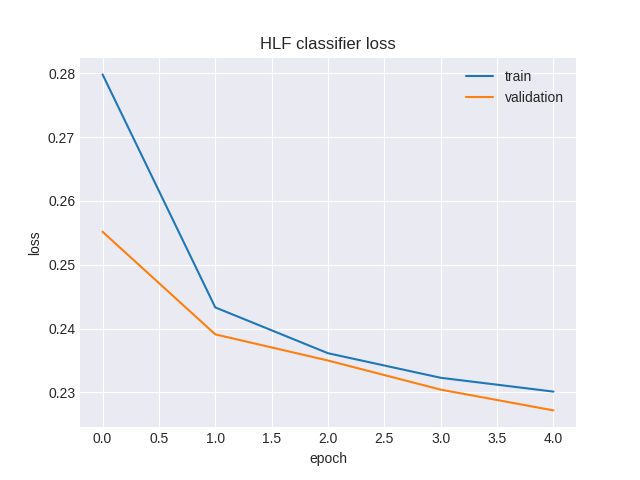

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


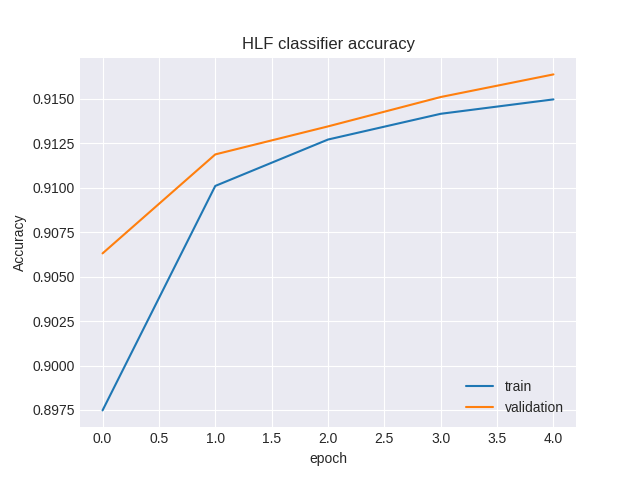

In [13]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [14]:
y_pred=history.model.predict(X_test)
y_true=y_test

In [15]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9164


<IPython.core.display.Javascript object>


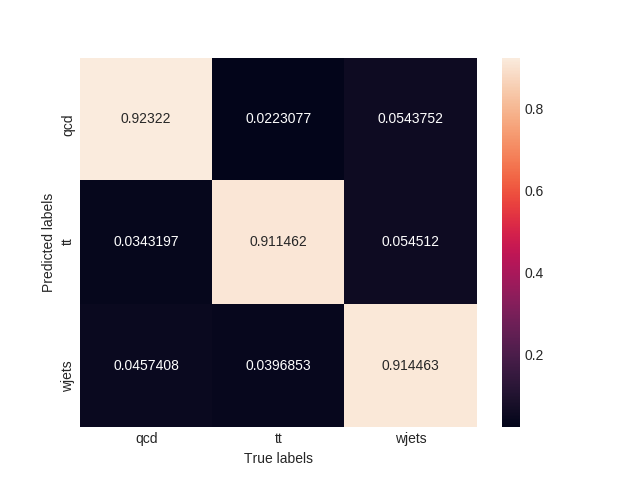

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [17]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [18]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9874097428496796, 1: 0.9856290300776949, 2: 0.9814107498814256}

<IPython.core.display.Javascript object>


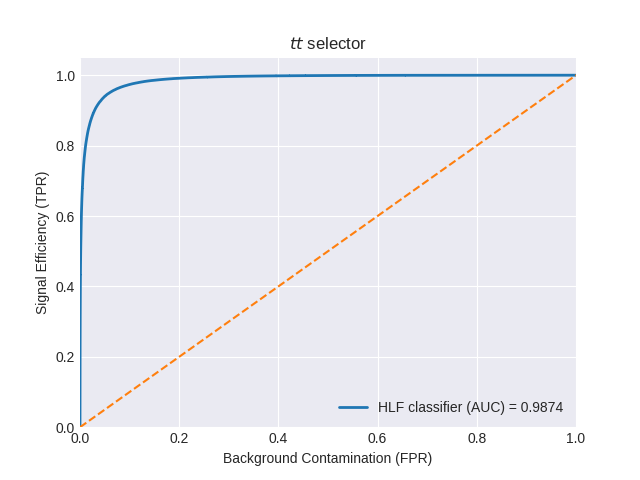

In [19]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()